In [9]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home/gsatopo1/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator
import dask.array as da

from scipy import integrate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

LC_path='/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/'

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def LC_params(line):
    h=0.678
    zmin = 2.5;zmax = 3.5
    zmid=(zmax+zmin)/2
    R=700
    ang_lim=10*u.deg
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=1,
                      spectral_supersample=1,
                      do_downsample=False,
                      cube_mode='inner_cube',
                      Nmu=20,
                      kmax=3*u.Mpc**-1,
                      dk=0.02*u.Mpc**-1,
                      seed=0)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                    RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim,
                    RA_min=-ang_lim,RA_max=ang_lim, DEC_min=-ang_lim,DEC_max=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, 
                    do_angular_smooth=True, do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.81568736,'beta':3.43531917,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params

In [4]:
def halos_in_Tbin(LC, Tbin_min, Tbin_max):
    LC_map=LC.obs_3d_map
    corners=LC_map.x
    
    inds_RA = (LC.halo_catalog['RA'] > LC.RAObs_min.value)&(LC.halo_catalog['RA'] < LC.RAObs_max.value)
    inds_DEC = (LC.halo_catalog['DEC'] > LC.DECObs_min.value)&(LC.halo_catalog['DEC'] < LC.DECObs_max.value)
    inds_sky = inds_RA&inds_DEC

    cornerside = (LC.raside_lim[1]**2+LC.decside_lim[1]**2)**0.5
    ang = np.arctan(cornerside/LC.rside_obs_lim[1])
    rbuffer = cornerside/np.sin(ang)
    zbuffer = LC.cosmo.redshift_at_comoving_radial_distance((rbuffer*LC.Mpch).value)
    nu_min = LC.line_nu0['CO_J10']/(zbuffer+1)

    inds = (LC.nuObs_line_halo['CO_J10'] >= nu_min)&(LC.nuObs_line_halo['CO_J10'] <= LC.nuObs_max)&inds_sky
    halos_in_survey = LC.halo_catalog[inds]
    
    zmid = (LC.line_nu0[LC.target_line]/LC.nuObs_mean).decompose().value-1
    sigma_par_target = (cu.c*LC.dnu*(1+zmid)/(LC.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*LC.nuObs_mean)).to(LC.Mpch).value

    Lbox = LC.Lbox.value

    Nmesh = np.array([LC.spectral_supersample*np.ceil(Lbox[0]/sigma_par_target),
              LC.angular_supersample*LC.Npixside[0],
              LC.angular_supersample*LC.Npixside[1]], dtype=int)

    ramid = 0.5*(LC.RAObs_max + LC.RAObs_min)
    decmid = 0.5*(LC.DECObs_max + LC.DECObs_min)

    ralim = np.deg2rad(np.array([LC.RAObs_min.value,LC.RAObs_max.value]) - ramid.value) 
    declim = np.deg2rad(np.array([LC.DECObs_min.value,LC.DECObs_max.value]) - decmid.value)
    raside_lim = LC.raside_lim
    decside_lim = LC.decside_lim
    rside_obs_lim = LC.rside_obs_lim

    mins_obs = np.array([rside_obs_lim[0],raside_lim[0],decside_lim[0]])+0.49999*Lbox/Nmesh

    ra,dec,redshift = da.broadcast_arrays(LC.halos_in_survey['CO_J10']['RA'], LC.halos_in_survey['CO_J10']['DEC'],
                                          LC.halos_in_survey['CO_J10']['Zobs'])
    r = redshift.map_blocks(lambda zz: (((LC.cosmo.comoving_radial_distance(zz)*u.Mpc).to(LC.Mpch)).value),
                            dtype=redshift.dtype)
    ra -= ramid.value
    dec -= decmid.value
    ra,dec  = da.deg2rad(ra),da.deg2rad(dec)

    x = da.cos(dec) * da.cos(ra)
    y = da.cos(dec) * da.sin(ra)
    z = da.sin(dec)
    pos = da.vstack([x,y,z]).T                    
    cartesian_halopos = r[:,None] * pos
    lategrid = np.array(cartesian_halopos.compute())

    filtering = (lategrid[:,0] >= rside_obs_lim[0]) & (lategrid[:,0] <= rside_obs_lim[1]) & \
                (lategrid[:,1] >= raside_lim[0]) & (lategrid[:,1] <= raside_lim[1]) & \
                (lategrid[:,2] >= decside_lim[0]) & (lategrid[:,2] <= decside_lim[1])
    lategrid = lategrid[filtering]
    for n in range(3):
        lategrid[:,n] -= mins_obs[n]
        
    Xcorner=np.sort(np.asarray(corners[0][:,0,0]))
    Xcorner-=np.min(Xcorner)
    dXcorner=np.diff(Xcorner)[0]
    Ycorner=np.sort(np.asarray(corners[1][0,:,0]))
    Ycorner-=np.min(Ycorner)
    dYcorner=np.diff(Ycorner)[0]
    Zcorner=np.sort(np.asarray(corners[2][0,0,:]))
    Zcorner-=np.min(Zcorner)
    dZcorner=np.diff(Zcorner)[0]

    ind_mask=np.asarray(np.where((LC_map>=Tbin_min)&(LC_map<Tbin_max)))
    Xmin=Xcorner[ind_mask[0]]
    Ymin=Ycorner[ind_mask[1]]
    Zmin=Zcorner[ind_mask[2]]

    mask_M=((lategrid[:,0]>=Xmin[0])&(lategrid[:,0]<Xmin[0]+dXcorner)&
            (lategrid[:,1]>=Ymin[0])&(lategrid[:,1]<Ymin[0]+dYcorner)&
            (lategrid[:,2]>=Zmin[0])&(lategrid[:,2]<Zmin[0]+dZcorner))
    for i in range(1,len(Xmin)):
        mask_M=mask_M|((lategrid[:,0]>=Xmin[i])&(lategrid[:,0]<Xmin[i]+dXcorner)&
                       (lategrid[:,1]>=Ymin[i])&(lategrid[:,1]<Ymin[i]+dYcorner)&
                       (lategrid[:,2]>=Zmin[i])&(lategrid[:,2]<Zmin[i]+dZcorner))

    M_in_Tbin=np.asarray((halos_in_survey['M_HALO'][filtering])[mask_M]*(LC_CO.Mpch.to(u.Mpc)))
    L_in_Tbin=np.asarray((LC_CO.halos_in_survey['CO_J10']['Lhalo'][filtering])[mask_M])
    return M_in_Tbin, L_in_Tbin

In [3]:
LC_CO=make_measurements(LC_params('CO'))

In [50]:
ang_lim=1.25*u.deg

LC_CO.update(RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim)

In [4]:
#TiCO_edge=np.logspace(-1, np.log10(np.max(CO_map)), 50+1)
TiCO_edge=np.linspace(-3, 30, 50+1)
TiCO=(TiCO_edge[:-1]+TiCO_edge[1:])/2.

BiCO=np.histogram(np.asarray(LC_CO.obs_3d_map).flatten(), bins=TiCO_edge)[0]

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.2260928678521218
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [52]:
print(BiCO[1], BiCO[4], BiCO[11], BiCO[25])

13395 81836 10080 1701


In [114]:
print(BiCO[1], BiCO[4], BiCO[11], BiCO[25])

362 11956 1019 129


In [99]:
print(BiCO[1], BiCO[4], BiCO[11], BiCO[25])

73779 588882 69962 12057


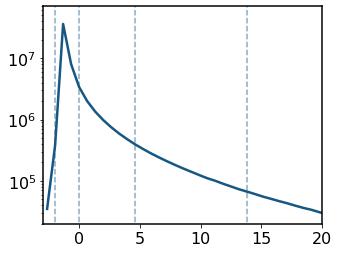

In [14]:
plt.figure(figsize=(5,4))
plt.plot(TiCO, BiCO)
plt.plot(TiCO[1]*np.ones((10)), np.logspace(1,15,10), '--C0', alpha=0.5, linewidth=1.5)
plt.plot(TiCO[4]*np.ones((10)), np.logspace(1,15,10), '--C0', alpha=0.5, linewidth=1.5)
plt.plot(TiCO[11]*np.ones((10)), np.logspace(1,15,10), '--C0', alpha=0.5, linewidth=1.5)
plt.plot(TiCO[25]*np.ones((10)), np.logspace(1,15,10), '--C0', alpha=0.5, linewidth=1.5)
plt.ylim(2e4,7e7)
plt.xlim(-3, 20)
plt.yscale('log')

In [33]:
TiCO_edge=np.linspace(-3, 30, 50+1)
M_in_T1, L_in_T1=halos_in_Tbin(LC_CO, TiCO_edge[1], TiCO_edge[1+1])
M_in_T11, L_in_T11=halos_in_Tbin(LC_CO, TiCO_edge[11], TiCO_edge[11+1])

In [53]:
TiCO_edge=np.linspace(-3, 30, 50+1)
M_in_T4, L_in_T4=halos_in_Tbin(LC_CO, TiCO_edge[4], TiCO_edge[4+1])

In [ ]:
TiCO_edge=np.linspace(-3, 30, 50+1)
M_in_T25, L_in_T25=halos_in_Tbin(LC_CO, TiCO_edge[25], TiCO_edge[25+1])

In [36]:
#np.save('M_in_Tbin1', M_in_T1)
#np.save('L_in_Tbin1', L_in_T1)
#np.save('M_in_Tbin11', M_in_T11)
#np.save('L_in_Tbin11', L_in_T11)

In [7]:
M_in_T1=np.load('../../M_in_Tbin1_v2.npy')
L_in_T1=np.load('../../L_in_Tbin1_v2.npy')

M_in_T4=np.load('../../M_in_Tbin4.npy')
L_in_T4=np.load('../../L_in_Tbin4.npy')

M_in_T11=np.load('../../M_in_Tbin11.npy')
L_in_T11=np.load('../../L_in_Tbin11.npy')

M_in_T25=np.load('../../M_in_Tbin25.npy')
L_in_T25=np.load('../../L_in_Tbin25.npy')

In [21]:
print(TiCO[1], TiCO[4], TiCO[11], TiCO[25])

-2.01 -0.029999999999999805 4.59 13.83


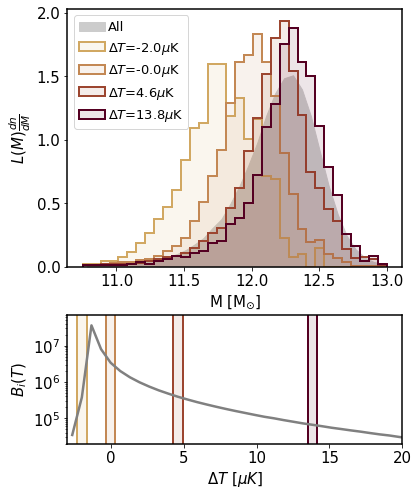

In [10]:
grey='#cccccc'
color1='#d1a862'
color2='#c38854'
color3='#9c4630'
color4='#550022'

Mbin_edges=np.linspace(10.75, 13, 35)
Mbin=(Mbin_edges[1:]+Mbin_edges[:-1])/2
#Nbin_tot, _=np.histogram(np.log10(M_in_survey), bins=Mbin_edges, weights=L_in_survey, density=True)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.25}, figsize=(6,8))

ax[0].fill_between(Mbin, y1=np.zeros((len(Mbin))), y2=Nbin_tot, color=grey, label='All')

ax[0].hist(np.log10(M_in_T1), bins=Mbin_edges, weights=L_in_T1, density=True, 
         color=color1, fc=(209/255, 168/255, 98/255, 0.1),
         linewidth=2, histtype='step', fill=True, label=r'$\Delta T$='+str(np.round(TiCO[1], 0))+r'$\mu$K')

ax[0].hist(np.log10(M_in_T4), bins=Mbin_edges, weights=L_in_T4, density=True, 
         color=color2, fc=(195/255, 136/255, 84/255, 0.1),
         linewidth=2, histtype='step', fill=True, label=r'$\Delta T$='+str(np.round(TiCO[4], 0))+r'$\mu$K')

ax[0].hist(np.log10(M_in_T11), bins=Mbin_edges, weights=L_in_T11, density=True, 
         color=color3, fc=(156/255, 70/255, 48/255, 0.1),
         linewidth=2, histtype='step', fill=True, label=r'$\Delta T$='+str(np.round(TiCO[11], 1))+r'$\mu$K')

ax[0].hist(np.log10(M_in_T25), bins=Mbin_edges, weights=L_in_T25, density=True, 
         color=color4, fc=(85/255, 0, 34/255, 0.1),
         linewidth=2,histtype='step', fill=True, label=r'$\Delta T$='+str(np.round(TiCO[25], 1))+r'$\mu$K')
ax[0].legend(loc='upper left', handletextpad=0.2, fontsize=13)
ax[0].set_xlabel('M [M$_{\odot}$]')
ax[0].set_ylabel(r'$L(M) \frac{dn}{dM}$')

ax[1].plot(TiCO, BiCO, color='grey')
ax[1].fill_betweenx(np.logspace(1,15,10), x1=TiCO_edge[1]*np.ones((10)), x2=TiCO_edge[2]*np.ones((10)), 
                    color=color1, fc=(209/255, 168/255, 98/255, 0.1), linewidth=2)

ax[1].fill_betweenx(np.logspace(1,15,10), x1=TiCO_edge[4]*np.ones((10)), x2=TiCO_edge[5]*np.ones((10)), 
                    color=color2, fc=(195/255, 136/255, 84/255, 0.1), linewidth=2)

ax[1].fill_betweenx(np.logspace(1,15,10), x1=TiCO_edge[11]*np.ones((10)), x2=TiCO_edge[12]*np.ones((10)), 
                    color=color3, fc=(156/255, 70/255, 48/255, 0.1), linewidth=2)

ax[1].fill_betweenx(np.logspace(1,15,10), x1=TiCO_edge[25]*np.ones((10)), x2=TiCO_edge[26]*np.ones((10)), 
                    color=color4, fc=(85/255, 0, 34/255, 0.1), linewidth=2)

ax[1].set_ylim(2e4,7e7)
ax[1].set_xlim(-3, 20)
ax[1].set_xlabel(r"$\Delta T$ [$\mu K$]")
ax[1].set_ylabel("$B_{i}(T)$")
ax[1].set_yscale('log')
#plt.savefig('../../VID_properties.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

cornerside = (LC_CO.raside_lim[1]**2+LC_CO.decside_lim[1]**2)**0.5
ang = np.arctan(cornerside/LC_CO.rside_obs_lim[1])
rbuffer = cornerside/np.sin(ang)
zbuffer = LC_CO.cosmo.redshift_at_comoving_radial_distance((rbuffer*LC_CO.Mpch).value)
nu_min = LC_CO.line_nu0['CO_J10']/(zbuffer+1)

inds = (LC_CO.nuObs_line_halo['CO_J10'] >= nu_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)&inds_sky
halos_in_survey = LC_CO.halo_catalog[inds]

In [6]:
zmid = (LC_CO.line_nu0[LC_CO.target_line]/LC_CO.nuObs_mean).decompose().value-1
sigma_par_target = (cu.c*LC_CO.dnu*(1+zmid)/(LC_CO.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*LC_CO.nuObs_mean)).to(LC_CO.Mpch).value

Lbox = LC_CO.Lbox.value

Nmesh = np.array([LC_CO.spectral_supersample*np.ceil(Lbox[0]/sigma_par_target),
          LC_CO.angular_supersample*LC_CO.Npixside[0],
          LC_CO.angular_supersample*LC_CO.Npixside[1]], dtype=int)

ramid = 0.5*(LC_CO.RAObs_max + LC_CO.RAObs_min)
decmid = 0.5*(LC_CO.DECObs_max + LC_CO.DECObs_min)

ralim = np.deg2rad(np.array([LC_CO.RAObs_min.value,LC_CO.RAObs_max.value]) - ramid.value) 
declim = np.deg2rad(np.array([LC_CO.DECObs_min.value,LC_CO.DECObs_max.value]) - decmid.value)
raside_lim = LC_CO.raside_lim
decside_lim = LC_CO.decside_lim
rside_obs_lim = LC_CO.rside_obs_lim

mins_obs = np.array([rside_obs_lim[0],raside_lim[0],decside_lim[0]])+0.49999*Lbox/Nmesh

ra,dec,redshift = da.broadcast_arrays(LC_CO.halos_in_survey['CO_J10']['RA'], LC_CO.halos_in_survey['CO_J10']['DEC'],
                                      LC_CO.halos_in_survey['CO_J10']['Zobs'])
r = redshift.map_blocks(lambda zz: (((LC_CO.cosmo.comoving_radial_distance(zz)*u.Mpc).to(LC_CO.Mpch)).value),
                        dtype=redshift.dtype)
ra -= ramid.value
dec -= decmid.value
ra,dec  = da.deg2rad(ra),da.deg2rad(dec)

x = da.cos(dec) * da.cos(ra)
y = da.cos(dec) * da.sin(ra)
z = da.sin(dec)
pos = da.vstack([x,y,z]).T                    
cartesian_halopos = r[:,None] * pos
lategrid = np.array(cartesian_halopos.compute())

filtering = (lategrid[:,0] >= rside_obs_lim[0]) & (lategrid[:,0] <= rside_obs_lim[1]) & \
            (lategrid[:,1] >= raside_lim[0]) & (lategrid[:,1] <= raside_lim[1]) & \
            (lategrid[:,2] >= decside_lim[0]) & (lategrid[:,2] <= decside_lim[1])

M_in_survey = np.asarray((halos_in_survey['M_HALO'][filtering])*(LC_CO.Mpch.to(u.Mpc)))
L_in_survey = np.asarray((LC_CO.halos_in_survey['CO_J10']['Lhalo'][filtering]))

In [8]:
print(np.min(lategrid[:,0]),np.max(lategrid[:,0]))
print(np.min(lategrid[:,1]),np.max(lategrid[:,1]))
print(np.min(lategrid[:,2]),np.max(lategrid[:,2]))

-4.505033612562329 157.73414727167528
-2.3715182756652666 1424.8447461244582
-2.3692418153898416 1424.853120117014


In [14]:
np.std(np.asarray(CO_map).flatten())

0.0

In [79]:
NTbin=[2,4,7,22]
CO_map=np.asarray(LC_CO.obs_3d_map)

Xcorner=np.sort(np.asarray(corners[0][:,0,0]))
Xcorner-=np.min(Xcorner)
dXcorner=np.diff(Xcorner)[0]
Ycorner=np.sort(np.asarray(corners[1][0,:,0]))
Ycorner-=np.min(Ycorner)
dYcorner=np.diff(Ycorner)[0]
Zcorner=np.sort(np.asarray(corners[2][0,0,:]))
Zcorner-=np.min(Zcorner)
dZcorner=np.diff(Zcorner)[0]

M_in_Tbin=[]
L_in_Tbin=[]

for n in NTbin:
    print(n)
    Tbin_min=TiCO_edge[n]
    Tbin_max=TiCO_edge[n+1]

    ind_mask=np.asarray(np.where((CO_map>=Tbin_min)&(CO_map<Tbin_max)))

    Xmin=Xcorner[ind_mask[0]]
    Ymin=Ycorner[ind_mask[1]]
    Zmin=Zcorner[ind_mask[2]]

    mask_M=((lategrid[:,0]>=Xmin[0])&(lategrid[:,0]<Xmin[0]+dXcorner)&
            (lategrid[:,1]>=Ymin[0])&(lategrid[:,1]<Ymin[0]+dYcorner)&
            (lategrid[:,2]>=Zmin[0])&(lategrid[:,2]<Zmin[0]+dZcorner))
    for i in range(1,len(Xmin)):
        mask_M=mask_M|((lategrid[:,0]>=Xmin[i])&(lategrid[:,0]<Xmin[i]+dXcorner)&
                       (lategrid[:,1]>=Ymin[i])&(lategrid[:,1]<Ymin[i]+dYcorner)&
                       (lategrid[:,2]>=Zmin[i])&(lategrid[:,2]<Zmin[i]+dZcorner))

    M_in_Tbin.append(np.asarray((halos_in_survey['M_HALO'][filtering])[mask_M]*(LC_CO.Mpch.to(u.Mpc))))
    L_in_Tbin.append(np.asarray((LC_CO.halos_in_survey['CO_J10']['Lhalo'][filtering])[mask_M]))

2
4
7
22
